# MTEB

For evaluation of embedding models, MTEB is one of the most well-known benchmark. In this tutorial, we'll introduce MTEB, its basic usage, and evaluate how your model performs on the MTEB leaderboard.

## 0. Installation

Install the packages we will use in your environment:

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
%%capture
%pip install sentence_transformers mteb

## 1. Intro

The [Massive Text Embedding Benchmark (MTEB)](https://github.com/embeddings-benchmark/mteb) is a large-scale evaluation framework designed to assess the performance of text embedding models across a wide variety of natural language processing (NLP) tasks. Introduced to standardize and improve the evaluation of text embeddings, MTEB is crucial for assessing how well these models generalize across various real-world applications. It contains a wide range of datasets in eight main NLP tasks and different languages, and provides an easy pipeline for evaluation.

MTEB is also well known for the MTEB leaderboard, which contains a ranking of the latest first-class embedding models. We'll cover that in the next tutorial. Now let's have a look on how to use MTEB to do evaluation easily.

In [3]:
import mteb
from sentence_transformers import SentenceTransformer

/home/jinho/miniconda3/envs/llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now let's take a look at how to use MTEB to do a quick evaluation.

First we load the model that we would like to evaluate on:

In [4]:
model_name = "BAAI/bge-base-en-v1.5"
model = SentenceTransformer(model_name)

Below is the list of datasets of retrieval used by MTEB's English leaderboard.

MTEB directly use the open source benchmark BEIR in its retrieval part, which contains 15 datasets (note there are 12 subsets of CQADupstack).

In [5]:
retrieval_tasks = [
    "ArguAna",
    "ClimateFEVER",
    "CQADupstackAndroidRetrieval",
    "CQADupstackEnglishRetrieval",
    "CQADupstackGamingRetrieval",
    "CQADupstackGisRetrieval",
    "CQADupstackMathematicaRetrieval",
    "CQADupstackPhysicsRetrieval",
    "CQADupstackProgrammersRetrieval",
    "CQADupstackStatsRetrieval",
    "CQADupstackTexRetrieval",
    "CQADupstackUnixRetrieval",
    "CQADupstackWebmastersRetrieval",
    "CQADupstackWordpressRetrieval",
    "DBPedia",
    "FEVER",
    "FiQA2018",
    "HotpotQA",
    "MSMARCO",
    "NFCorpus",
    "NQ",
    "QuoraRetrieval",
    "SCIDOCS",
    "SciFact",
    "Touche2020",
    "TRECCOVID",
]

For demonstration, let's just run the first one, "ArguAna".

For a full list of tasks and languages that MTEB supports, check the [page](https://github.com/embeddings-benchmark/mteb/blob/18662380f0f476db3d170d0926892045aa9f74ee/docs/tasks.md).

In [6]:
from __future__ import annotations

from mteb.abstasks.TaskMetadata import TaskMetadata

from mteb.abstasks.AbsTaskRetrieval import AbsTaskRetrieval

import json


class AizipTesla(AbsTaskRetrieval):
    ignore_identical_ids = True

    metadata = TaskMetadata(
        name="Aizip_Tesla_Manual",
        description="NFCorpus: A Full-Text Learning to Rank Dataset for Medical Information Retrieval",
        reference="http://argumentation.bplaced.net/arguana/data",
        dataset={
            "path": "mteb/arguana",
            "revision": "c22ab2a51041ffd869aaddef7af8d8215647e41a",
        },
        type="Retrieval",
        category="s2p",
        modalities=["text"],
        eval_splits=["test"],
        eval_langs=["eng-Latn"],
        main_score="ndcg_at_10",
        date=None,
        domains=["Medical", "Written"],
        task_subtypes=None,
        license="cc-by-sa-4.0",
        annotations_creators=None,
        dialect=[],
        sample_creation=None,
        bibtex_citation="""@inproceedings{boteva2016,
  author = {Boteva, Vera and Gholipour, Demian and Sokolov, Artem and Riezler, Stefan},
  title = {A Full-Text Learning to Rank Dataset for Medical Information Retrieval},
  journal = {Proceedings of the 38th European Conference on Information Retrieval},
  journal-abbrev = {ECIR},
  year = {2016},
  city = {Padova},
  country = {Italy},
  url = {http://www.cl.uni-heidelberg.de/~riezler/publications/papers/ECIR2016.pdf}
}""",
        prompt={"query": "Given a claim, find documents that refute the claim"},
    )

    def load_data(self, **kwargs):
        if self.data_loaded:
            return
        self.corpus, self.queries, self.relevant_docs = {}, {}, {}
        
        dir_name = "aizip_tesla"

        with open(f"{dir_name}/corpus.json", "r") as f:
            self.corpus = {'test': json.loads(f.read())}

        with open(f"{dir_name}/queries.json", "r") as f:
            self.queries = {'test': json.loads(f.read())}

        with open(f"{dir_name}/qrels.json", "r") as f:
            self.relevant_docs = {'test': json.loads(f.read())}

        self.data_loaded = True


In [7]:
tesla_task = AizipTesla()

In [8]:
tasks = mteb.get_tasks(tasks=retrieval_tasks[:1])

Then, create and initialize an MTEB instance with our chosen tasks, and run the evaluation process.

In [9]:
# use the tasks we chose to initialize the MTEB instance
evaluation = mteb.MTEB(tasks=[tesla_task])

In [10]:
# use the tasks we chose to initialize the MTEB instance
# evaluation = mteb.MTEB(tasks=tasks)

evaluation = mteb.MTEB(tasks=[tesla_task])

# call run() with the model and output_folder
# results = evaluation.run(model, output_folder="results")

In [21]:
# use the tasks we chose to initialize the MTEB instance
evaluation = mteb.MTEB(tasks=[tesla_task])

scores = []

index = "ndcg_at_3"

for i in range(11):
    alpha = round(0.1 * i, 2)

    dir_name = f"results/alpha={alpha}"

    # Check if directory exists, create if not
    os.makedirs(dir_name, exist_ok=True) 

    # call run() with the model and output_folder
    results = evaluation.run(model, output_folder=dir_name, alpha=alpha)
    
    score = results[0].scores['test'][0][index]
    
    scores.append(score)

    print("SCORE:", score)

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- Aizip_Tesla_Manual, s2p

SCORE: 0.58788


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- Aizip_Tesla_Manual, s2p

SCORE: 0.71948


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- Aizip_Tesla_Manual, s2p

SCORE: 0.73855


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- Aizip_Tesla_Manual, s2p

SCORE: 0.75007


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- Aizip_Tesla_Manual, s2p

SCORE: 0.75398


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- Aizip_Tesla_Manual, s2p

SCORE: 0.75322


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- Aizip_Tesla_Manual, s2p

SCORE: 0.74394


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- Aizip_Tesla_Manual, s2p

SCORE: 0.72999


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- Aizip_Tesla_Manual, s2p

SCORE: 0.69931


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- Aizip_Tesla_Manual, s2p

SCORE: 0.65596


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- Aizip_Tesla_Manual, s2p

SCORE: 0.58788


In [26]:
len(tesla_task.corpus['test'])

496

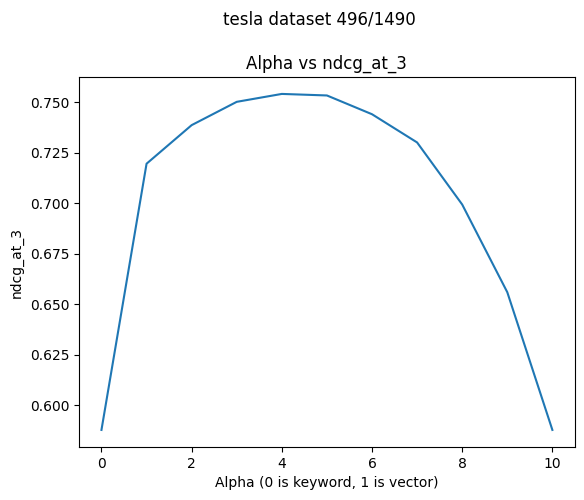

In [27]:
import matplotlib.pyplot as plt

plt.plot(scores)
plt.xlabel('Alpha (0 is keyword, 1 is vector)')
plt.ylabel(index)
plt.title(f'Alpha vs {index}')
plt.suptitle('tesla dataset 496/1490', fontsize=12, y=1.02)
plt.show()